In [1]:
import warnings
warnings.filterwarnings('ignore')

In [32]:
import pandas as pd
import scipy
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import classification_report,confusion_matrix

import numpy as np

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

In [3]:
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

Using TensorFlow backend.


In [4]:
def resume(clf,X_test,y_test):
    print(classification_report(y_test,clf.predict(X_test)))
    print(confusion_matrix(y_test,clf.predict(X_test)))

In [5]:
from ast import literal_eval
data = pd.read_csv("./data/sentence_analysis.csv",sep="#",converters={"tokens":literal_eval, "senetences":literal_eval, "vocab":literal_eval, "lemma_vocab":literal_eval, "capitalized_words":literal_eval, "misspelled":literal_eval, "words":literal_eval})

In [6]:
# spliter le jeux de données en des partie test et train
train_index= list()
test_index = list()
for lang in data.lang.unique():
    r = data[data.lang == lang] 
    train, test = train_test_split(r,test_size=0.11)
    train_index.append(list(train.index))
    test_index.append(list(test.index))
test_index = [x for l in test_index for x in l]
train_index = [x for l in train_index for x in l]

train = data.loc[train_index]
test = data.loc[test_index]

label = LabelEncoder()
std = StandardScaler()
tfidf = TfidfVectorizer(dtype="float32",ngram_range=(1,2))

X1_train = std.fit_transform(train[train.columns[10:]])
X1_test  = std.transform(test[test.columns[10:]])

X1_train = scipy.sparse.csr_matrix(X1_train)
X1_test  = scipy.sparse.csr_matrix(X1_test)

X2_train = tfidf.fit_transform(train.text)
X2_test  = tfidf.transform(test.text)

X_train = scipy.sparse.hstack([X1_train,X2_train])
X_test  = scipy.sparse.hstack([X1_test,X2_test])

y_train = label.fit_transform(train.lang)
y_test = label.transform(test.lang)

In [28]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid,valid_y,is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

# Word2Vect (skipgram,cbow)

# Glov

In [ ]:
embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

# Fast Text 

In [23]:
# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('data/wiki-news-300d-1M.vec',encoding="utf8")):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

In [ ]:
# transformation du text en des word sequance 

In [14]:
# comment faire pour construire 
from keras.preprocessing.text import  Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=800) # ici je met à 800 car c'est la borne max
tokenizer.fit_on_texts(train.text)
seq_train = tokenizer.texts_to_sequences(train.text)
seq_test  = tokenizer.texts_to_sequences(test.text)

word_index = tokenizer.word_index

In [20]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

text_len = 250
X_train = pad_sequences(seq_train,maxlen=text_len)
X_test  = pad_sequences(seq_test, maxlen=text_len)

In [47]:
# transformation du vocabulaire en  des embaddings 
index_word = {v:k for k,v in word_index.items()}
embedding_matrix = np.zeros((len(word_index) +1, 300))
for i in range(len(word_index)):
    try :
        embedding_vector = embeddings_index[index_word[i+1]]
    except :
        embedding_vector = np.random.rand(300)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [57]:
from keras.layers import Embedding
embedding_layer = Embedding(len(word_index) +1,
                                300,
                                weights=[embedding_matrix],
                                input_length=text_len,
                                trainable=False)

from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import Model

sequence_input = Input(shape=(text_len,))
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, padding='same', activation='relu')(embedded_sequences) #en same, pas de division, on garde 100
x = MaxPooling1D(5)(x) #divise 100/5=20
x = Conv1D(128, 5, padding='same', activation='relu')(x)
x = MaxPooling1D(20)(x)  # global max pooling on prend ce qui reste
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(11, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

# happy learning!
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=100, batch_size=128)
# model.fit(x_train, y_train, epochs=2, batch_size=128)

Train on 8811 samples, validate on 1089 samples
Epoch 1/100
8811/8811 [==============================] - 47s 5ms/step - loss: 2.3763 - acc: 0.1178 - val_loss: 2.3620 - val_acc: 0.1084
Epoch 2/100
8811/8811 [==============================] - 48s 5ms/step - loss: 2.3297 - acc: 0.1445 - val_loss: 2.2961 - val_acc: 0.1561
Epoch 3/100
8811/8811 [==============================] - 50s 6ms/step - loss: 2.2313 - acc: 0.2017 - val_loss: 2.1584 - val_acc: 0.2176
Epoch 4/100
8811/8811 [==============================] - 51s 6ms/step - loss: 2.1181 - acc: 0.2582 - val_loss: 2.4685 - val_acc: 0.1781
Epoch 5/100
8811/8811 [==============================] - 51s 6ms/step - loss: 2.0130 - acc: 0.2919 - val_loss: 2.1735 - val_acc: 0.2231
Epoch 6/100
8811/8811 [==============================] - 51s 6ms/step - loss: 1.9104 - acc: 0.3395 - val_loss: 2.0385 - val_acc: 0.2489
Epoch 7/100
8811/8811 [==============================] - 51s 6ms/step - loss: 1.7931 - acc: 0.3793 - val_loss: 2.0465 - val_acc: 0.2617


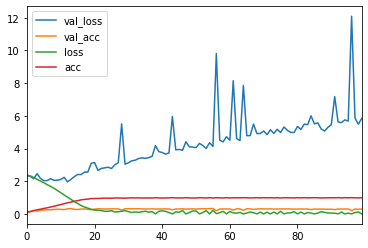

In [63]:
pd.DataFrame(history.history).plot()

In [72]:
# test des word embaddings word2vect

from gensim.models import Word2Vec
from gensim.test.utils import common_texts

w2v = Word2Vec(data.words, size=100, window=5, min_count=1, workers=4,)

In [90]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=800)
tokenizer.fit_on_texts(train.text)

seq_train = tokenizer.texts_to_sequences(train.text)
seq_test = tokenizer.texts_to_sequences(test.text)

index_word = {v:k for k,v in tokenizer.word_index.items()}

seq_train = pad_sequences(seq_train,maxlen=500)
seq_test  = pad_sequences(seq_test,maxlen=500)

In [94]:
# création de la matrice index : embedding
embedding_matrix = np.zeros((len(w2v.wv.vocab)+1,100))
for i in range(1,len(w2v.wv.vocab)+1):
    try :
        embedding_matrix[i]= w2v.wv[index_word[i]]
    except :
        embedding_matrix[i] = np.zeros(100)

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.91010821,  0.58875179, -0.93864435, ..., -0.12314958,
         0.25510356,  3.49911737],
       [ 0.25275078,  0.36520189, -1.88235056, ..., -0.35453802,
        -0.60953981,  1.31378484],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])